In [1]:
import pandas as pd
import seaborn as sb 
import xgboost as xg
import numpy as np
import lightgbm as lgb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import randint, uniform

In [ ]:
test = pd.read_csv('data/test.csv')

In [12]:
train = pd.read_csv('data/train.csv', index_col=0)
train.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


Сразу можно заметить, что есть категориальные признаки, но их немного. Таргет - 'Fertilizer Name'.

In [13]:
origin = pd.read_csv('data/Fertilizer Prediction.csv')
origin.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,32,51,41,Red,Ground Nuts,7,3,19,14-35-14
1,35,58,35,Black,Cotton,4,14,16,Urea
2,27,55,43,Sandy,Sugarcane,28,0,17,20-20
3,33,56,56,Loamy,Ground Nuts,37,5,24,28-28
4,32,70,60,Red,Ground Nuts,4,6,9,14-35-14


In [9]:
origin.shape

(100000, 9)

In [11]:
train.shape

(750000, 9)

Оба датасета будут использоваться в качестве обучающих, поэтому важно, чтобы они имели одинаковое количество столбцов (признаков).

In [12]:
origin.isna().any()

Temparature        False
Humidity           False
Moisture           False
Soil Type          False
Crop Type          False
Nitrogen           False
Potassium          False
Phosphorous        False
Fertilizer Name    False
dtype: bool

In [54]:
train.isna().any()

Temparature        False
Humidity           False
Moisture           False
Soil Type          False
Crop Type          False
Nitrogen           False
Potassium          False
Phosphorous        False
Fertilizer Name    False
dtype: bool

В данных отсутвуют пропуски.

In [13]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      100000 non-null  int64 
 1   Humidity         100000 non-null  int64 
 2   Moisture         100000 non-null  int64 
 3   Soil Type        100000 non-null  object
 4   Crop Type        100000 non-null  object
 5   Nitrogen         100000 non-null  int64 
 6   Potassium        100000 non-null  int64 
 7   Phosphorous      100000 non-null  int64 
 8   Fertilizer Name  100000 non-null  object
dtypes: int64(6), object(3)
memory usage: 6.9+ MB


In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      750000 non-null  int64 
 1   Humidity         750000 non-null  int64 
 2   Moisture         750000 non-null  int64 
 3   Soil Type        750000 non-null  object
 4   Crop Type        750000 non-null  object
 5   Nitrogen         750000 non-null  int64 
 6   Potassium        750000 non-null  int64 
 7   Phosphorous      750000 non-null  int64 
 8   Fertilizer Name  750000 non-null  object
dtypes: int64(6), object(3)
memory usage: 57.2+ MB


Всего два категориальных признака: 'Soil Type', 'Crop Type'.

In [56]:
train['Soil Type'].value_counts()

Sandy     156710
Black     150956
Clayey    148382
Red       148102
Loamy     145850
Name: Soil Type, dtype: int64

In [57]:
train['Crop Type'].value_counts()

Paddy          85754
Pulses         78180
Cotton         69171
Tobacco        68000
Wheat          66628
Millets        65291
Barley         65045
Sugarcane      64269
Oil seeds      64184
Maize          62569
Ground Nuts    60909
Name: Crop Type, dtype: int64

Можно заметить, что в данных признаках нет дисбаланса.

In [58]:
train['Fertilizer Name'].value_counts()

14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: Fertilizer Name, dtype: int64

In [14]:
origin['Fertilizer Name'].value_counts()

14-35-14    14492
10-26-26    14378
Urea        14325
28-28       14232
DAP         14220
20-20       14181
17-17-17    14172
Name: Fertilizer Name, dtype: int64

По целевой переменной дисбаланса классов не наблюдается. Это говорит о том, что при использовании кросс-валидации нет необходимости соблюдать распределение классов. Также нет необходимости использовать различные функции для весов в функции потерь, учитывающих распределение классов.

In [14]:
train.describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [15]:
origin.describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.00000
mean,31.503300,60.985810,45.00344,22.986770,9.472220,21.01348
std,4.019942,6.651393,11.83871,11.247289,5.768565,12.39118
min,25.000000,50.000000,25.00000,4.000000,0.000000,0.00000
25%,28.000000,55.000000,35.00000,13.000000,4.000000,10.00000
50%,32.000000,61.000000,45.00000,23.000000,9.000000,21.00000
75%,35.000000,67.000000,55.00000,33.000000,14.000000,32.00000
max,38.000000,72.000000,65.00000,42.000000,19.000000,42.00000


Если посмотреть на статистики двух датасетов, то: 1. они имеют схожие значения статистик, что говорит о том, что у соответствующих признаков одинаковое распределение. 2. зачастую мода и среднее близки, что говорит о симметричности данных 3. нет каких-то значительных выбросов. Все это говорит о том, что данные не требуют дополнительной работы с выбрасами (удаление, замена в датасете или на этапе построения модели).

In [7]:
col_OHE = ['Soil Type','Crop Type']
encoder = OneHotEncoder(sparse=False, drop='first')

In [8]:
enc = encoder.fit_transform(train[col_OHE])
enc

array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [9]:
enc_or = encoder.fit_transform(origin[col_OHE])

In [10]:
enc_data =pd.DataFrame(enc, columns=encoder.get_feature_names_out(col_OHE)) 
train = pd.concat([train, enc_data], axis=1)
train = train.drop(col_OHE,axis=1)

In [11]:
enc_data =pd.DataFrame(enc_or, columns=encoder.get_feature_names_out(col_OHE)) 
origin = pd.concat([origin, enc_data], axis=1)
origin = origin.drop(col_OHE,axis=1)

In [ ]:
enc_test = encoder.fit_transform(test[col_OHE])
enc_data =pd.DataFrame(enc_test, columns=encoder.get_feature_names_out(col_OHE)) 
test = pd.concat([test, enc_data], axis=1)
test = test.drop(col_OHE,axis=1)

Одним из вариантов кодирования категориальных признаков является OneHot. Он пригодится в будущем, если у модели не будет встроенного энкодера. Поскольку категориальных признаков всего два, использование даного метода не сделает датасет слишком большим. И, в отличии от Label Encoder, не произведет никаких ложных зависимостей.

C:\Users\Huawei\AppData\Local\Temp\ipykernel_10024\2904415573.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(train.corr())


<AxesSubplot: >

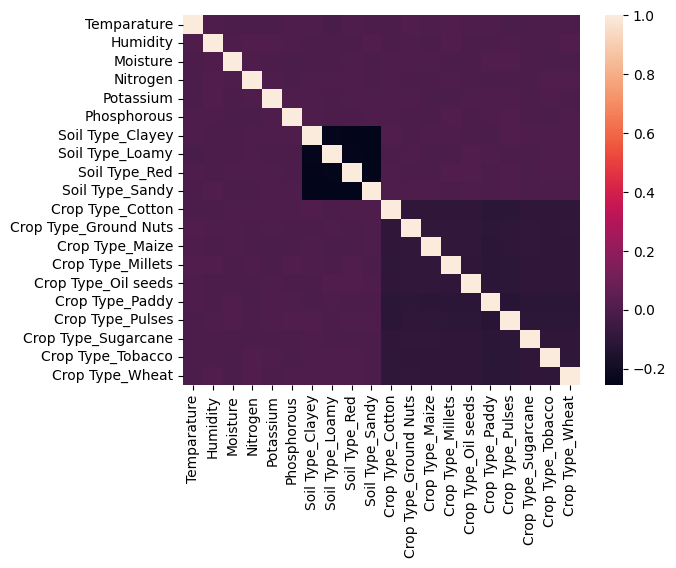

In [66]:
sb.heatmap(train.corr())

Если посмореть на визуализацию корреляцию между признаками, то видно, что сильной корреляции между ними нет. Т.е. нет линейно зависимых признаков.

In [18]:
cat_col = train.select_dtypes(include='object').columns.to_list()

In [19]:
num_col = train.select_dtypes(include = 'int').columns.to_list()

Получение списков численных и категориальных признаков.

In [20]:
num_col

['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

Хоть и порядок значений в каждом признаке схожий (т.е. не будет проблемы с весами), все равно можно провести нормализацию данных.

In [16]:
scaler = StandardScaler()

In [ ]:
train[num_col] = scaler.fit_transform(train[num_col])
origin[num_col] = scaler.fit_transform(origin[num_col])
test[num_col] = scaler.fit_transform(test[num_col])

In [23]:
LE = LabelEncoder()

In [24]:
X = pd.concat([train, origin], axis=0)
Y = X['Fertilizer Name']
X = X.drop('Fertilizer Name', axis=1)
Y = LE.fit_transform(Y)

К целевой переменной можно применить LabelEncoder, поскольку не во всех модель предусмтрена работа с нечисловыми классами.

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

Разделение на на тестовую и обучающую выборку имеет смысл только на этапе поиска решения, поскольку финальный score в соревновании будет определяться на отдельной тестовой выборке.

Начнем с простых. Первые две модели - Логистическая регрессия и метод опорных векторов. В случае, если зависимость между таргетом и признаками имеет линейный вид, можгут быть хорошими решениеми.

In [ ]:
LogReg = LogisticRegression(solver='lbfgs',
                    multi_class='multinomial', 
                    max_iter=1000)
LogReg.fit(X_train, Y_train)
y_pred_logreg = LogReg.predict(X_test)

In [ ]:
supp = SVC(kernel='linear', max_iter=1000)
supp.fit(X,Y)
y_pred_supp = supp.predict(X_train,Y_train)

In [ ]:
res_logreg = classification_report(Y_test, y_pred_logreg)
print(res_logreg)

In [ ]:
res_svc = classification_report(Y_test, y_pred_supp)
print(res_svc)

### Mean Average Precision @ 3 (MAP@3)

Формула оценки:

```math
MAP@3 = \frac{1}{U} \sum_{u=1}^{U} \sum_{k=1}^{\min(n,3)} P(k) \times rel(k)

Логистическая регрессия показала слишком низкое качество классификации (MAP = 0.21566), как и метод опорных векторов (= 0.20057) поэтому необходимо взять другую модель. Плохое качество может говорить о том, что истинная зависимость имеет нелинейный характер.

Хорошим решением этой проблемы могут быть деревья решений. Есть смысл сразу взять самый мощный из всех подобных алгоритмов - градиентный бустинг над решающими деревьями. Для подбора гиперпаратмеров модели воспользуемся кросс-валидацией kFold и поиском RandomSearch. 

In [26]:
kFold = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
model_xgb = xg.XGBClassifier(
    object = 'multi:softprob',
    num_class = len(np.unique(Y)),
    random_state=42,
    eval_metric='mlogloss',
    device='cuda',
    tree_method='hist',
)

In [ ]:
param_xgb = {
    'max_depth': randint(2,15),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(2000, 10000),
    'subsample': uniform(0.2,1),
    'colsample_bytree': uniform(0.2,1),
    'gamma': uniform(0.2,1)
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_xgb,
    cv=kFold,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, Y_train)

Вообще можно было использовать всю выборку для поиска, поскольку даже если модель получит какие то "знания" о тестовой выборке, то это никак не отразится на выборке, на которой будет считаться финальный score.

In [ ]:
xgb_model = xg.XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(Y)),
    learning_rate=0.03,
    max_depth=8,
    n_estimators=10000,
    subsample=0.8,
    colsample_bytree=0.45,
    random_state=42,
    eval_metric='mlogloss',
    device='cuda',
    tree_method='hist'
)
xgb_model.fit(X_train, Y_train)
y_pred_xgb = xgb_model.predict(X_test)
res_xgb = classification_report(Y_test, y_pred_xgb)
print(res_xgb)

Градиентный бустинг XGBoost дал score сильно лучше (=0.35510), чем логистическая регрессия. Возможные улучшения: добавление признаков, использование анасамбля бустингов (бэггинг, стэкинг).

В качестве преобразования признаков будет использоваться полинимиальное преобразование (полином степени 2). Это позволить внести неленейные зависимости.

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
train_poly = pd.DataFrame(poly.fit_transform(train[num_col]),
                        columns=poly.get_feature_names_out(num_col), 
                      index=train.index)
train = pd.concat([train_poly, train[cat_col]], axis=1)
origin_poly = pd.DataFrame(poly.fit_transform(origin[num_col]),
                        columns=poly.get_feature_names_out(num_col), 
                      index=origin.index)
origin = pd.concat([origin_poly, origin[cat_col]], axis=1)
test_poly = pd.DataFrame(poly.fit_transform(test[num_col]),
                        columns=poly.get_feature_names_out(num_col), 
                      index=origin.index)
test = pd.concat([test_poly, test[cat_col]], axis=1)

In [ ]:
X = pd.concat([train, origin], axis=0)
Y = X['Fertilizer Name']
X = X.drop('Fertilizer Name', axis=1)
Y = LE.fit_transform(Y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

Далее произведем стекинг, где в качестве базовых моделей: XGBoost, LGBM, логистическая регрессия. В качестве метамодели: XGBoost.

In [29]:
estimators = [
    ('xgb_1', xg.XGBClassifier(
        max_depth=7,
        colsample_bytree=0.4,
        subsample=0.8,
        n_estimators=5000,
        learning_rate=0.01,
        gamma=0.26,
        max_delta_step=4,
        reg_alpha=2.7,
        reg_lambda=1.4,
        objective='multi:softprob',
        random_state=13,
        enable_categorical=True,
        tree_method='hist',
        device='cuda'
    )),
    ('lr', LogisticRegression(
        C=1e-2,
        max_iter=3000,
        random_state=0
    )),
    ('lgbm', lgb.LGBMClassifier(
        learning_rate=0.028305385633320197,
        num_leaves=156,
        max_depth=11,
        min_child_samples=79,
        subsample=0.7918343506574987,
        colsample_bytree=0.5091819990144888,
        reg_alpha=2.978706459636553,
        reg_lambda=6.8587096602092865,
        device='gpu' 
    ))
]

In [ ]:
meta_model = xg.XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(Y)),
    learning_rate=0.03,
    max_depth=8,
    n_estimators=10000,
    subsample=0.8,
    colsample_bytree=0.45,
    random_state=42,
    eval_metric='mlogloss',
    device='cuda',
    tree_method='hist',
    early_stopping_rounds=100
)

In [ ]:
stack = StackingClassifier(estimators=estimators,
                           final_estimator=meta_model,
                           cv = 5,
                           stack_method='predict_proba',
                           n_jobs=-1
                           )
stack.fit(X_train, Y_train)
y_pred_stack = stack.predict(X_train, Y_train)

Стэкинг не дал сильно преимущества в score (= 0.35734). Это может говорить о том, что алгоритм градиентного бустинга уже достаточно хорошо справляется с данной задачей, поэтому не стоит так усложнять подход.

Последней моделью будет бэггинг XGBoost, LGBM и CatBoost. Поскольку сами по себе эти алгоритмы хорошо предсказывают целевые классы (низкий bias), бэггинг поможет снизить дисперсию по выборке, что может улучшить скор.

In [ ]:
X = pd.concat([train, origin], axis=0)
Y = X['Fertilizer Name']
X = X.drop('Fertilizer Name', axis=1)
Y = LE.fit_transform(Y)

X_test = test

In [69]:
def kfold_LGBM(X_train, y_train_str, X_test, n_splits=5):
    y_train = LE.fit_transform(y_train_str)

    test_proba_folds = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr, y_tr = X_train.iloc[train_idx], y_train[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train[val_idx]

        model = lgb.LGBMClassifier(
            learning_rate=0.028305385633320197,
            num_leaves=156,
            max_depth=11,
            min_child_samples=79,
            subsample=0.7918343506574987,
            colsample_bytree=0.5091819990144888,
            reg_alpha=2.978706459636553,
            reg_lambda=6.8587096602092865,
            device='gpu' 
        )
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)],
                  callbacks=[lgb.early_stopping(100, verbose=False)])
        
        test_proba = model.predict_proba(X_test)
        test_proba_folds.append(test_proba)

    avg_test_proba = np.mean(test_proba_folds, axis=0)

    final_preds_int = np.argmax(avg_test_proba, axis=1)
    final_preds_str = LE.inverse_transform(final_preds_int)

    top_3_preds = np.argsort(avg_test_proba, axis=1)[:, -3:][:, ::-1]
    top_3_labels = LE.inverse_transform(top_3_preds.ravel()).reshape(top_3_preds.shape)

    return top_3_labels, avg_test_proba, LE

In [ ]:
def kfold_XGB(X_train, y_train_str, X_test, n_splits=5):
    y_train = LE.fit_transform(y_train_str)

    test_proba_folds = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr, y_tr = X_train.iloc[train_idx], y_train[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train[val_idx]

        model = xg.XGBClassifier(
            max_depth=7,
            colsample_bytree=0.4,
            subsample=0.8,
            n_estimators=5000,
            learning_rate=0.01,
            gamma=0.26,
            max_delta_step=4,
            reg_alpha=2.7,
            reg_lambda=1.4,
            objective='multi:softprob',
            random_state=13,
            enable_categorical=True,
            early_stopping_rounds=150,
            tree_method='hist',
            device='cuda'  
        )
        model.fit(X_tr, y_tr, 
                  eval_set=[(X_val, y_val)], 
                  verbose=100
                )

        test_proba = model.predict_proba(X_test)
        test_proba_folds.append(test_proba)

    avg_test_proba = np.mean(test_proba_folds, axis=0)

    final_preds_int = np.argmax(avg_test_proba, axis=1)
    final_preds_str = LE.inverse_transform(final_preds_int)

    top_3_preds = np.argsort(avg_test_proba, axis=1)[:, -3:][:, ::-1]
    top_3_labels = LE.inverse_transform(top_3_preds.ravel()).reshape(top_3_preds.shape)

    return top_3_labels, avg_test_proba, LE

In [ ]:
from catboost import CatBoostClassifier

def kfold_CatBoost(X_train, y_train_str, X_test, n_splits=5):
    y_train = LE.fit_transform(y_train_str)
    test_proba_folds = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr, y_tr = X_train.iloc[train_idx], y_train[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train[val_idx]

        model = CatBoostClassifier(
            loss_function='MultiClass',
            eval_metric='MultiClass',
            max_depth=8,
            learning_rate=0.1,
            colsample_bylevel=1,
            random_state=42,
            verbose=100,
            early_stopping_rounds=100,
            n_estimators=5000,
            l2_leaf_reg=0.12185512372394472,
            bagging_temperature=0.2119744763488629,
            min_data_in_leaf=2
            task_type="GPU"
        )

        model.fit(
            X_tr, y_tr,
            eval_set=(X_val, y_val),
            use_best_model=True
        )

        test_proba = model.predict_proba(X_test)
        test_proba_folds.append(test_proba)

    avg_test_proba = np.mean(test_proba_folds, axis=0)

    final_preds_int = np.argmax(avg_test_proba, axis=1)
    final_preds_str = LE.inverse_transform(final_preds_int)

    # Топ-3 класса по вероятностям
    top_3_preds = np.argsort(avg_test_proba, axis=1)[:, -3:][:, ::-1]
    top_3_labels = LE.inverse_transform(top_3_preds.ravel()).reshape(top_3_preds.shape)

    return top_3_labels, avg_test_proba, LE

In [ ]:
labels_CAT, proba_cat, le_cat = kfold_CatBoost(X, Y, X_test)
labels_LGBM, proba_lgbm, le_lgbm = kfold_LGBM(X, Y, X_test)
labels_XGB, proba_xgb, le_xgb = kfold_XGB(X, Y, X_test)

In [ ]:
avg_proba = (proba_lgbm + proba_xgb + proba_cat) / 3
top_3_preds = np.argsort(avg_proba, axis=1)[:, -3:][:, ::-1]
top_3_labels = le_lgbm.inverse_transform(top_3_preds.ravel()).reshape(top_3_preds.shape)

In [ ]:
test_ids = test['id']
    
submission_df = pd.DataFrame({
    'id': test_ids,
    'Fertilizer Name': [' '.join(preds) for preds in top_3_labels]
})
submission_df.to_csv('submission.csv', index=False)

Как итог, последний подход дал самое высокое значение скора (0.35838). Эта версия модели останется в качестве используемой для соревнования.